# Figures
Use `micromamba activate benchmark_env`.

In [5]:
library(ggplot2)
library(tidyverse)
library(ggridges)
library(repr)

# Histogram to show p-values are sysematically smaller for gpt-4o than for gpt-3.5.

In [6]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")

Rows: 29390 Columns: 15
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgnc, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in geom_histogram(bin = n_bins, fill = "blue", color = "black"):
“Ignoring unknown parameters: `bin`”


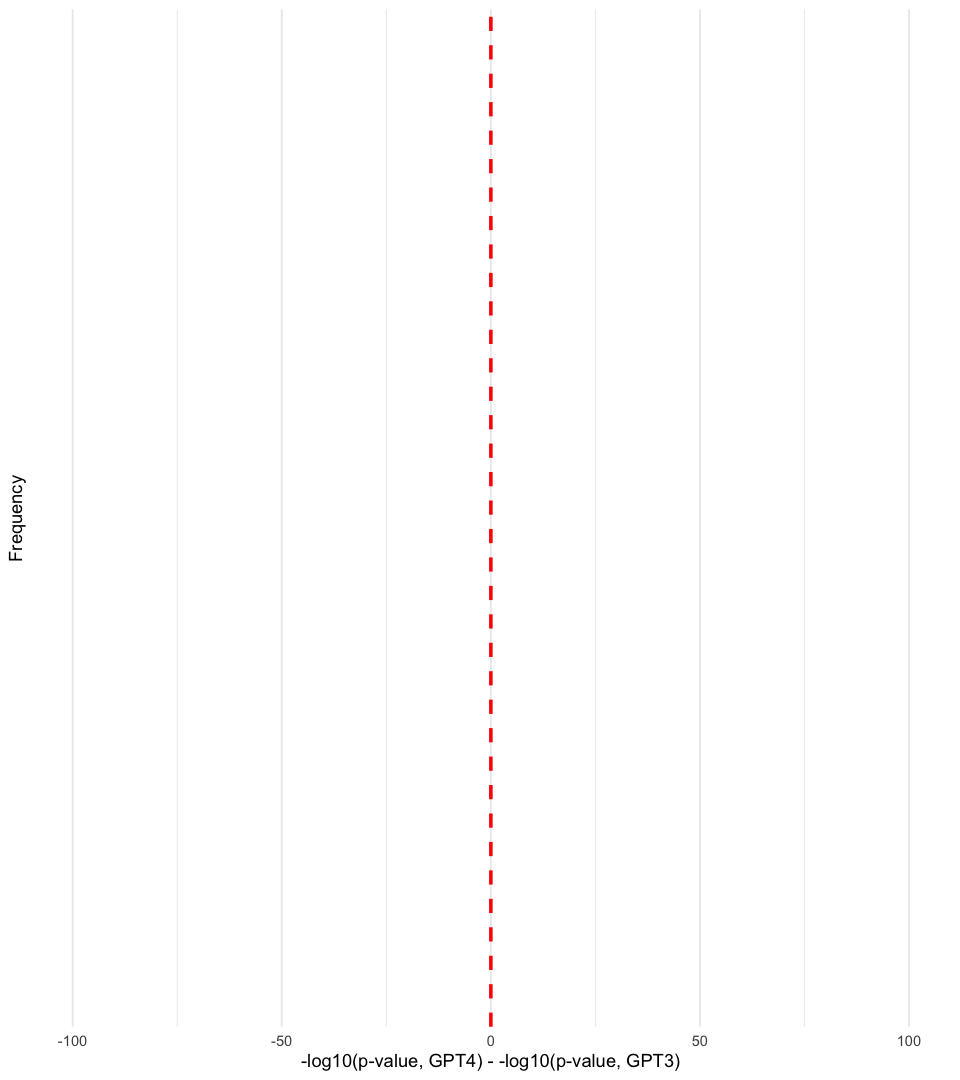

In [32]:
df <- df |> dplyr::filter(p_val_adj < 0.01)
df <- df |> dplyr::filter(gene_set == "llm_genes_role") 
#df <- df |> dplyr::filter(database=="WikiPathway_2023_Human")
df.gpt3 <- df |> dplyr::filter(model == "gpt-3.5-turbo-0125")
df.gpt4 <- df |> dplyr::filter(model == "gpt-4o-2024-08-06")

df.m <- merge(df.gpt3, df.gpt4, by="descr", suffixes = c(".gpt3", ".gpt4"))
df.m$p_val.gpt3 <- -log10(df.m$p_val.gpt3)
df.m$p_val.gpt4 <- -log10(df.m$p_val.gpt4)

df.m$diff <- df.m$p_val.gpt4 - df.m$p_val.gpt3 

freedman_diaconis_bins <- function(x) {
  h <- 2 * IQR(x) / (length(x)^(1/3))
  n_bins <- ceiling((max(x) - min(x)) / h)
  return(n_bins)
}
n_bins <- freedman_diaconis_bins(df.m$diff)

fig <- ggplot(df.m, aes(x = diff)) +
  geom_histogram(bin = n_bins, fill = "blue", color = "black") +
  geom_vline(aes(xintercept = 0), color = "red", linetype = "dashed", size = 1) +
  xlim(-100, 100) +
  labs(x = "-log10(p-value, GPT4) - -log10(p-value, GPT3)",
       y = "Frequency") +
  theme_minimal()
ggsave(fig, file="figures/p_value_diff_histogram.pdf", width = 4, height=4)
fig 

Plot to show generation times in seconds for various experiments.

Rows: 9 Columns: 6
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (4): gen_time_role, gen_time_norole, gen_time_reasoning, gen_time_conf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Saving 7 x 7 in image


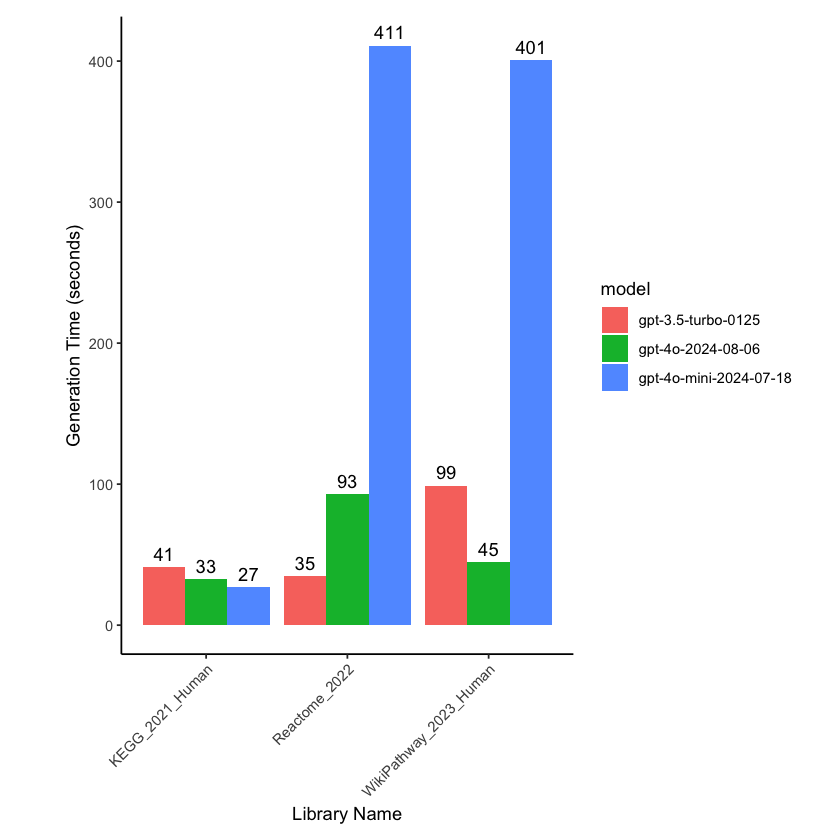

In [7]:
data <- readr::read_tsv("outputs/gen_time.tsv")
data$gen_time_role <- round(data$gen_time_role)

gen_fig <- ggplot(data, aes(x = lib_name, y = gen_time_role, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = gen_time_role), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  #scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

Rows: 45 Columns: 5
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): lib_name, model, gene_set
dbl (2): in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


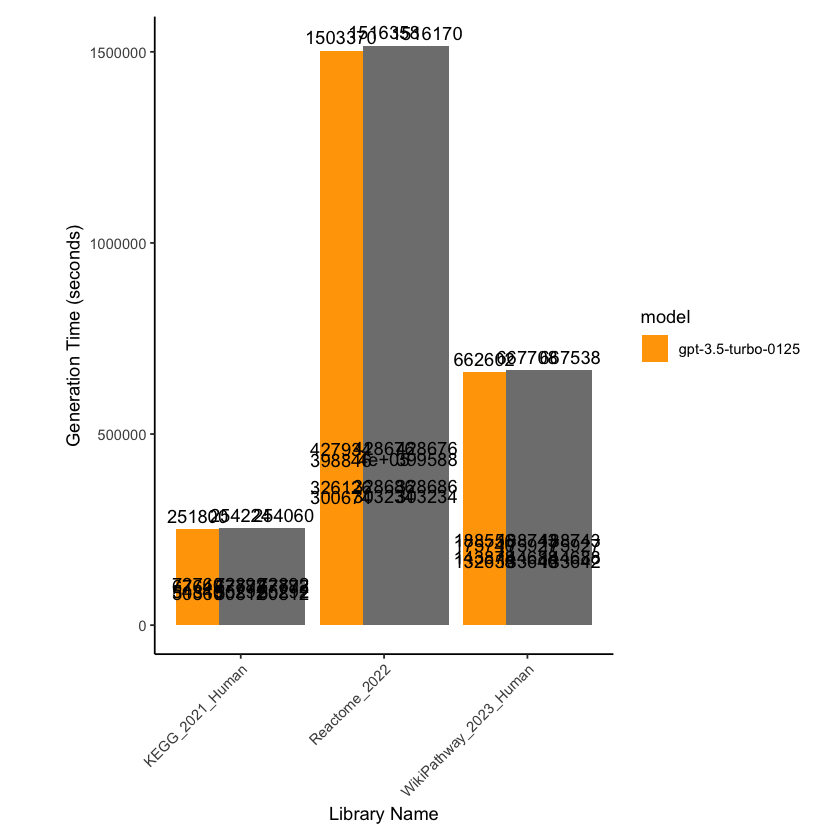

In [9]:
data <- readr::read_tsv("outputs/tok_use.tsv")

gen_fig <- ggplot(data, aes(x = lib_name, y = in_toks, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = in_toks), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

#ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

In [10]:
# Group by model and sum in_toks and out_toks
summarized_df <- data %>%
  group_by(model) %>%
  summarise(
    total_in_toks = sum(in_toks, na.rm = TRUE),
    total_out_toks = sum(out_toks, na.rm = TRUE)
  )
summarized_df

model,total_in_toks,total_out_toks
<chr>,<dbl>,<dbl>
gpt-3.5-turbo-0125,4757784,4412256
gpt-4o-2024-08-06,4788658,6988093
gpt-4o-mini-2024-07-18,4787720,6571513


# Show shift in precision for confidence and ensembling.

In [23]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")
unique(df$model)

Rows: 44085 Columns: 17
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (12): ncurated, nllm, ninter, generatio, bgratio, richFactor, foldEnrich...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "gpt-4o-mini-2024-07-18" "gpt-3.5-turbo-0125"     "gpt-4o-2024-08-06"

Warning message in geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", :
“Ignoring unknown parameters: `size`”
Warning message:
“Removed 620 rows containing non-finite outside the scale range (`stat_binline()`).”
Picking joint bandwidth of 0.0603

Warning message:
“Removed 620 rows containing non-finite outside the scale range (`stat_density_ridges()`).”
Warning message:
“Removed 620 rows containing non-finite outside the scale range (`stat_binline()`).”
Picking joint bandwidth of 0.0603

Warning message:
“Removed 620 rows containing non-finite outside the scale range (`stat_density_ridges()`).”


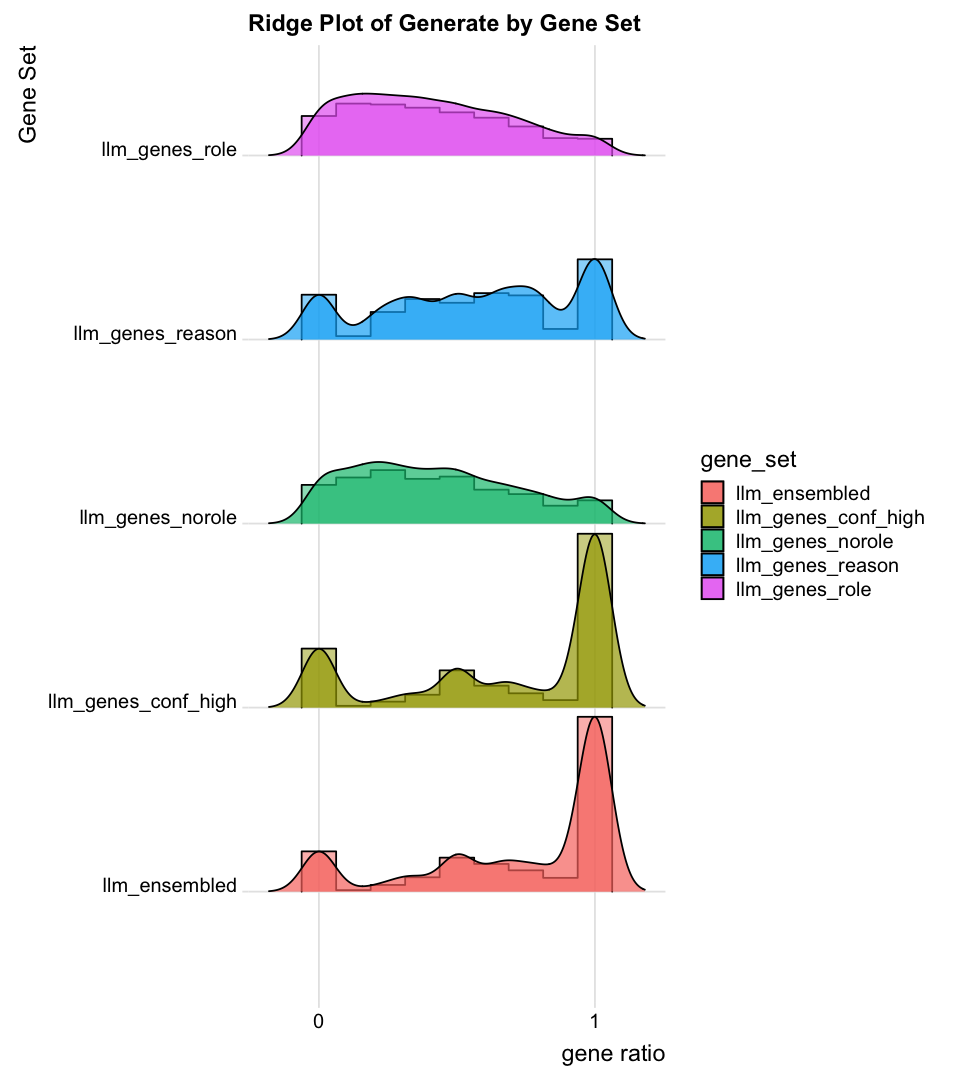

In [26]:

fig <- ggplot(df |> filter(model=="gpt-3.5-turbo-0125"), aes(x = richFactor, y = gene_set, fill = gene_set)) +
  geom_density_ridges(stat = "binline", bins = 9, scale = 0.95, draw_baseline = FALSE, alpha = 0.5) +
  geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", size = 0.3) +
  theme_ridges() + 
  labs(title = "Ridge Plot of Generate by Gene Set",
       x = "gene ratio",
       y = "Gene Set") +
scale_x_continuous(breaks = c(0, 1))

ggsave(fig, file="gene_ratio_gpt3.pdf", width=10,height=16)

options(repr.plot.width = 8, repr.plot.height = 9)  # Width = 10 inches, Height = 6 inches

fig


Warning message in geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", :
“Ignoring unknown parameters: `size`”
Warning message:
“Removed 189 rows containing non-finite outside the scale range (`stat_binline()`).”
Picking joint bandwidth of 0.0517

Warning message:
“Removed 189 rows containing non-finite outside the scale range (`stat_density_ridges()`).”
Warning message:
“Removed 189 rows containing non-finite outside the scale range (`stat_binline()`).”
Picking joint bandwidth of 0.0517

Warning message:
“Removed 189 rows containing non-finite outside the scale range (`stat_density_ridges()`).”


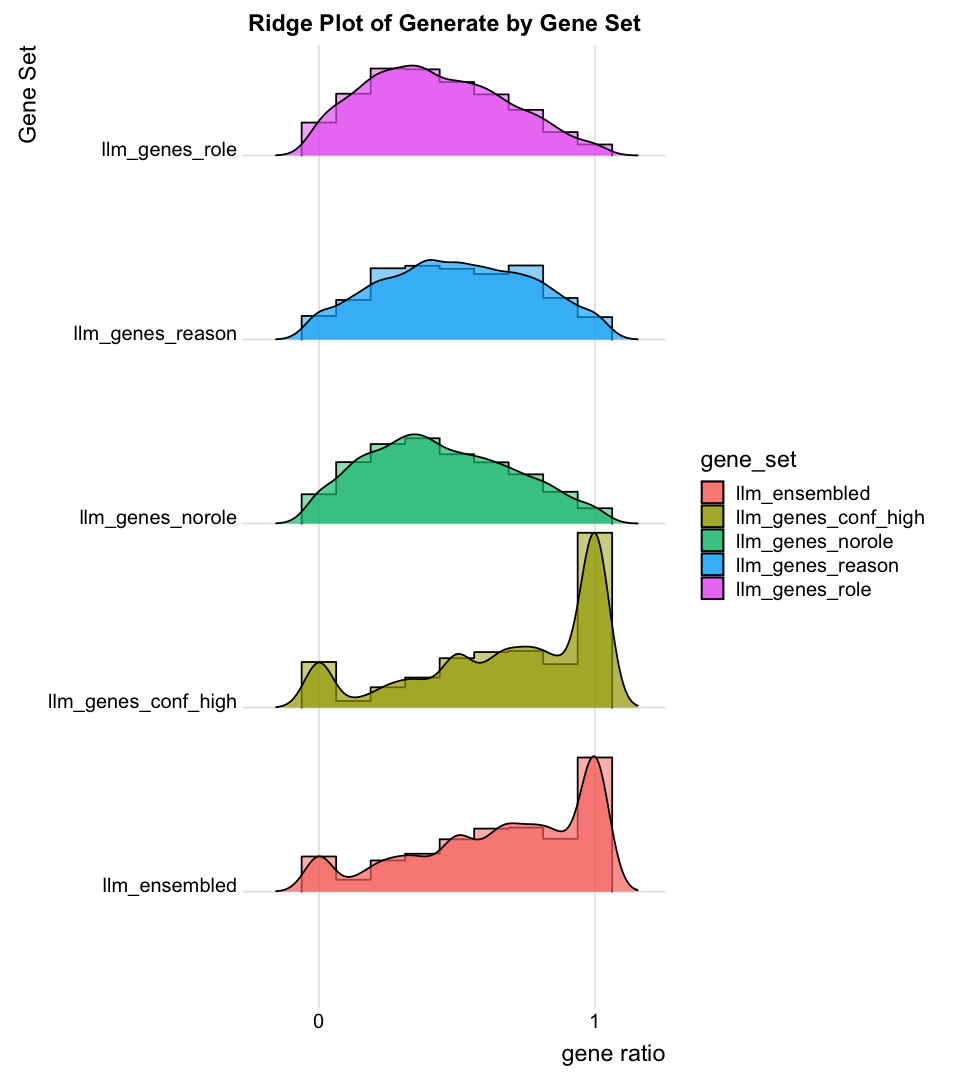

In [17]:

fig <- ggplot(df |> filter(model=="gpt-4o-2024-08-06"), aes(x = generatio, y = gene_set, fill = gene_set)) +
  geom_density_ridges(stat = "binline", bins = 9, scale = 0.95, draw_baseline = FALSE, alpha = 0.5) +
  geom_density_ridges(scale = 0.95, alpha = 0.7, color = "black", size = 0.3) +
  theme_ridges() + 
  labs(title = "Ridge Plot of Generate by Gene Set",
       x = "gene ratio",
       y = "Gene Set") +
scale_x_continuous(breaks = c(0, 1))

ggsave(fig, file="gene_ratio_gpt4.pdf", width=10,height=16)

options(repr.plot.width = 8, repr.plot.height = 9)  # Width = 10 inches, Height = 6 inches

fig


# Fraction of significant gene sets

In [14]:
df <- readr::read_tsv("outputs/genes_overlap.tsv")

Rows: 44085 Columns: 15
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgnc, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
df.gpt4 <- df |> filter(model == "gpt-4o-2024-08-06")
df.gpt3 <- df |> filter(model == "gpt-3.5-turbo-0125")

In [20]:
colnames(df.gpt4)

[1] "database"      "model"         "gene_set"      "descr"        
 [5] "descr_cleaned" "ncurated"      "nllm"          "ninter"       
 [9] "generatio"     "bgratio"       "non_hgnc"      "ntries"       
[13] "ndup"          "p_val"         "p_val_adj"

In [21]:
res.gpt4 <- df.gpt4 %>%
  group_by(database, gene_set) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))
res.gpt3 <- df.gpt3 %>%
  group_by(database, gene_set) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))

`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'database'. You can override using the `.groups` argument.


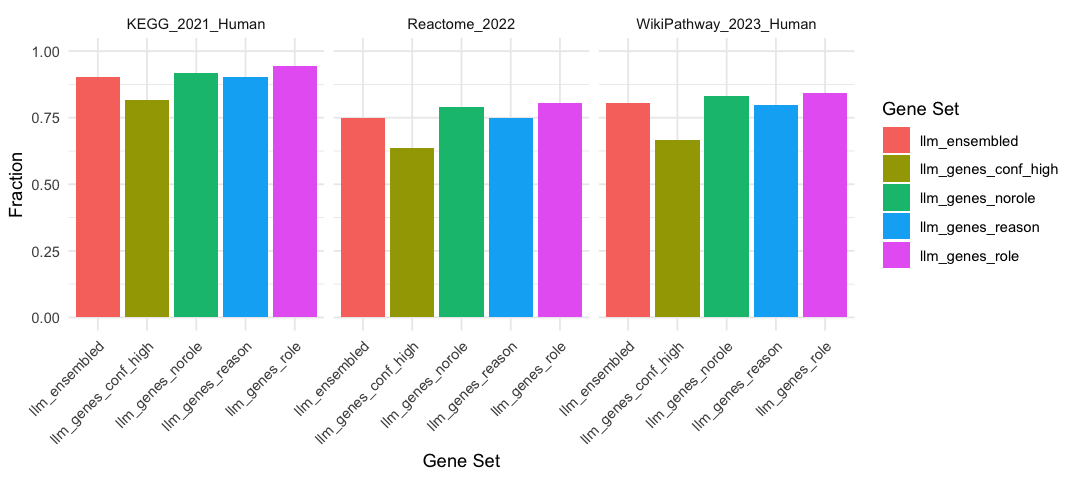

In [22]:
options(repr.plot.width = 9, repr.plot.height = 4)  
fig <- ggplot(res.gpt4, aes(x = gene_set, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity") +
  labs(x = "Gene Set", y = "Fraction", fill = "Gene Set") +
  facet_wrap(~database) +
  ylim(0,1) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(fig, file="gpt4_over.pdf", width=9, height=4)
fig 

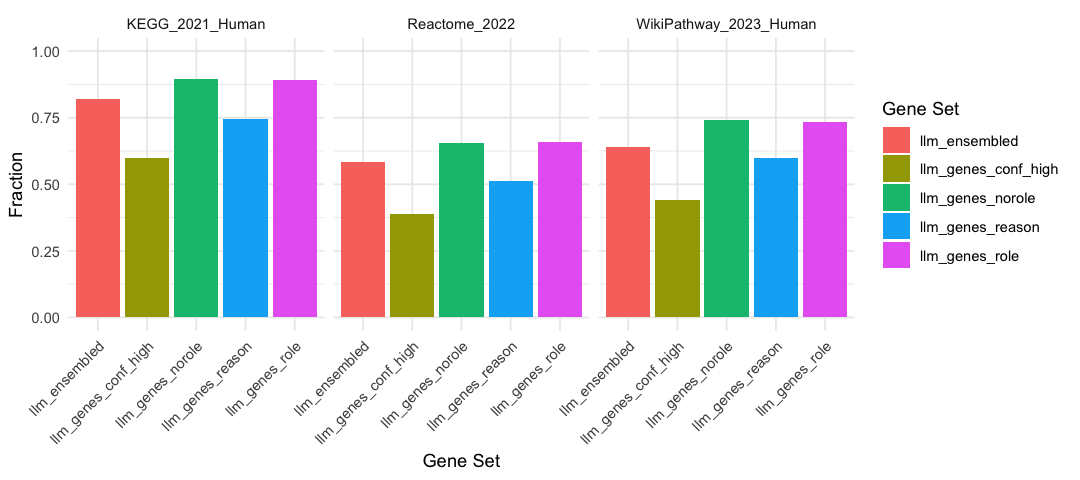

In [23]:
options(repr.plot.width = 9, repr.plot.height = 4)  
fig <- ggplot(res.gpt3, aes(x = gene_set, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity") +
  labs(x = "Gene Set", y = "Fraction", fill = "Gene Set") +
  facet_wrap(~database) +
  ylim(0,1) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(fig, file="gpt3_over.pdf", width=9, height=4)
fig 

# Fraction of significant gene sets comparing role prompt vs no role prompt

In [79]:
df <- readr::read_tsv("genes_overlap.tsv")
unique(df$gene_set)

Rows: 35268 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): database, model, gene_set, descr
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "llm_genes_role"             "llm_genes_norole"          
[3] "llm_genes_reason"           "llm_genes_conf_high"       
[5] "llm_genes_conf_high_medium" "llm_ensembled"

In [80]:
df <- df |> filter(gene_set %in% c("llm_genes_role", "llm_genes_norole"))

In [81]:
df <- df %>%
  group_by(database, gene_set, model) %>%
  summarise(fraction = mean(p_val_adj < 0.01, na.rm = TRUE))

`summarise()` has grouped output by 'database', 'gene_set'. You can override using the `.groups` argument.


In [82]:
df

database,gene_set,model,fraction
<chr>,<chr>,<chr>,<dbl>
KEGG_2021_Human,llm_genes_norole,gpt-3.5-turbo-0125,0.8968750
KEGG_2021_Human,llm_genes_norole,gpt-4o-2024-05-13,0.9312500
KEGG_2021_Human,llm_genes_role,gpt-3.5-turbo-0125,0.8968750
KEGG_2021_Human,llm_genes_role,gpt-4o-2024-05-13,0.9468750
Reactome_2022,llm_genes_norole,gpt-3.5-turbo-0125,0.6567657
Reactome_2022,llm_genes_norole,gpt-4o-2024-05-13,0.8058306
Reactome_2022,llm_genes_role,gpt-3.5-turbo-0125,0.6705171
Reactome_2022,llm_genes_role,gpt-4o-2024-05-13,0.8146315
WikiPathway_2023_Human,llm_genes_norole,gpt-3.5-turbo-0125,0.7378277


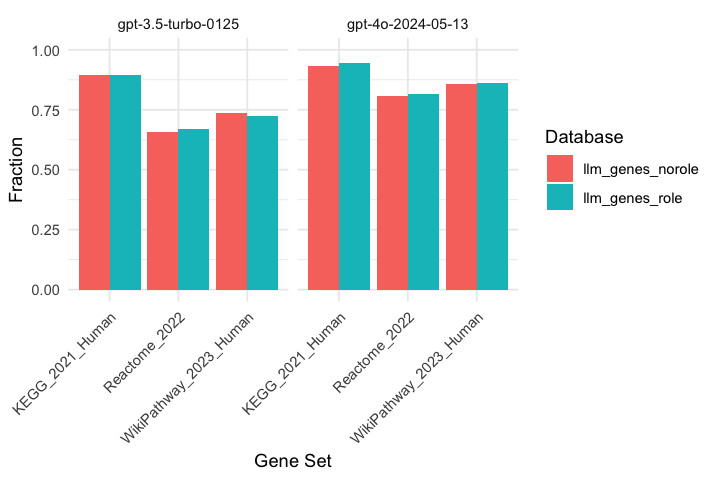

In [83]:
options(repr.plot.width = 6, repr.plot.height = 4)  
fig <- ggplot(df, aes(x = database, y = fraction, fill = gene_set)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Gene Set", y = "Fraction", fill = "Database") +
  facet_wrap(~model) +
  ylim(0, 1) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave(fig, file="role_vs_norole.pdf", width=6, height=4)
fig

# Are gene sets smaller?

In [2]:
df <- readr::read_tsv("genes_overlap.tsv")

Rows: 35268 Columns: 15
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): database, model, gene_set, descr, descr_cleaned
dbl (10): ncurated, nllm, ninter, generatio, bgratio, non_hgcn, ntries, ndup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df.gpt3 <- df |> dplyr::filter(model == "gpt-3.5-turbo-0125")
df.gpt4 <- df |> dplyr::filter(model == "gpt-4o-2024-05-13")

In [4]:
test.gpt4 <- df.gpt4 %>% 
        select(c("database", "descr", "descr_cleaned", "gene_set", "nllm")) %>% 
        pivot_wider(names_from=gene_set, values_from=nllm)
test.gpt3 <- df.gpt3 %>% 
        select(c("database", "descr", "descr_cleaned", "gene_set", "nllm")) %>% 
        pivot_wider(names_from=gene_set, values_from=nllm)

In [31]:

# all ensemble gene sets are smaller
sum(test.gpt4$llm_genes_norole >= test.gpt4$llm_ensembled, na.rm=T) / nrow(test.gpt4)
sum(test.gpt3$llm_genes_norole >= test.gpt3$llm_ensembled, na.rm=T) / nrow(test.gpt3)

sum(test.gpt4$llm_genes_norole < test.gpt4$llm_genes_reason, na.rm=T) / nrow(test.gpt4)
sum(test.gpt3$llm_genes_norole < test.gpt3$llm_genes_reason, na.rm=T) / nrow(test.gpt3)

sum(test.gpt4$llm_genes_norole < test.gpt4$llm_genes_conf_high, na.rm=T) / nrow(test.gpt4)
sum(test.gpt3$llm_genes_norole < test.gpt3$llm_genes_conf_high, na.rm=T) / nrow(test.gpt3)


#sum(test.gpt4$llm_genes_norole  test$llm_genes_reason)
#sum(test$llm_genes_norole < test$llm_genes_conf_high)

[1] 1

[1] 1

[1] 0.08506295

[1] 0.02653964

[1] 0.02619939

[1] 0.02143586

In [18]:
sum(is.na(test.gpt4$llm_genes_norole))

[1] 0

# generation time of each approach 

In [10]:
data <- readr::read_tsv("gen_time.tsv")

df_long <- data %>%
  pivot_longer(cols = c(gen_time_role, gen_time_norole, gen_time_reasoning, gen_time_conf), 
               names_to = "gene_set", values_to = "gen_time")
df_long

Rows: 6 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (4): gen_time_role, gen_time_norole, gen_time_reasoning, gen_time_conf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


lib_name,model,gene_set,gen_time
<chr>,<chr>,<chr>,<dbl>
KEGG_2021_Human,gpt-3.5-turbo-0125,gen_time_role,97.47154
KEGG_2021_Human,gpt-3.5-turbo-0125,gen_time_norole,59.64158
KEGG_2021_Human,gpt-3.5-turbo-0125,gen_time_reasoning,12.88457
KEGG_2021_Human,gpt-3.5-turbo-0125,gen_time_conf,15.75863
KEGG_2021_Human,gpt-4o-2024-05-13,gen_time_role,25.13838
KEGG_2021_Human,gpt-4o-2024-05-13,gen_time_norole,24.14684
KEGG_2021_Human,gpt-4o-2024-05-13,gen_time_reasoning,22.30365
KEGG_2021_Human,gpt-4o-2024-05-13,gen_time_conf,20.53953
Reactome_2022,gpt-3.5-turbo-0125,gen_time_role,65.46452


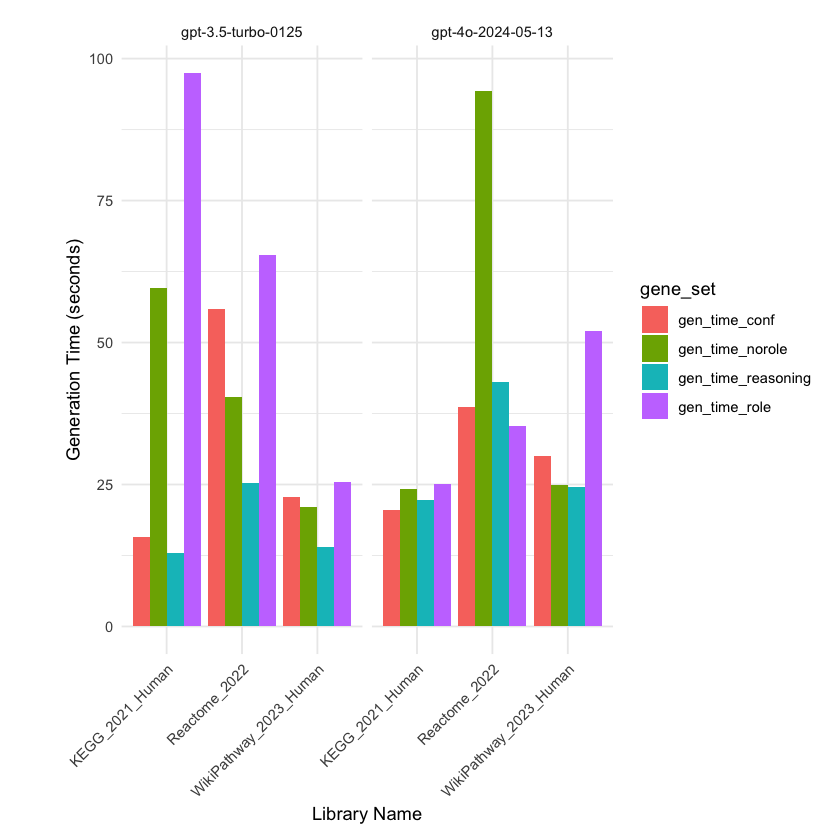

In [17]:


gen_fig <- ggplot(df_long, aes(x = lib_name, y = gen_time, fill = gene_set)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_wrap(~model) + 
 labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

ggsave(gen_fig, file="figures/gen_time_strategies.pdf", width=8, height=4)
gen_fig

# gsproposal versus gsai

In [2]:
llm2geneset <- readr::read_tsv("llm2geneset_outputs.tsv")
gsai <- readr::read_tsv("gsai_outputs.tsv")

Rows: 5878 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): model, library, gt_name, llm2geneset_name
dbl (4): llm2geneset_ROUGE1, llm2geneset_ROUGE2, llm2geneset_ROUGEL, llm2gen...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5878 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): model, library, gt_name, gsai_name
dbl (4): gsai_ROUGE1, gsai_ROUGE2, gsai_ROUGEL, gsai_csim

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
table(res$model)


gpt-3.5-turbo-0125  gpt-4o-2024-05-13 
              2947               2947 

In [20]:
res <- merge(gsai, llm2geneset)
res <- res %>% dplyr::filter(model == "gpt-4o-2024-05-13")

In [33]:
mean(res$gsai_ROUGEL, na.rm=T)
mean(res$llm2geneset_ROUGEL)

[1] 0.1901169

[1] 0.2101372

In [34]:
colnames(res)

[1] "model"              "library"            "gt_name"           
 [4] "gsai_name"          "gsai_ROUGE1"        "gsai_ROUGE2"       
 [7] "gsai_ROUGEL"        "gsai_csim"          "llm2geneset_name"  
[10] "llm2geneset_ROUGE1" "llm2geneset_ROUGE2" "llm2geneset_ROUGEL"
[13] "llm2geneset_csim"

In [35]:
wilcox.test(res$gsai_csim, res$llm2geneset_csim)


	Wilcoxon rank sum test with continuity correction

data:  res$gsai_csim and res$llm2geneset_csim
W = 4582750, p-value = 0.000213
alternative hypothesis: true location shift is not equal to 0


  gsai_ROUGE1 gsai_ROUGE2 gsai_ROUGEL gsai_csim llm2geneset_ROUGE1
1        1.00           1   0.5000000 0.6761516               1.00
2        0.00           0   0.0000000 0.3573473               0.00
3        0.00           0   0.0000000 0.4897165               0.00
4        0.00           0   0.0000000 0.4454520               1.00
5        0.25           0   0.1818182 0.5896624               0.25
6        0.00           0   0.0000000 0.1876963               0.00
  llm2geneset_ROUGE2 llm2geneset_ROUGEL llm2geneset_csim
1                  1          0.8000000        0.8251353
2                  0          0.0000000        0.2207613
3                  0          0.0000000        0.6060546
4                  1          1.0000000        0.9999988
5                  0          0.2857143        0.4666502
6                  0          0.0000000        0.1787629


Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_ydensity()`).”


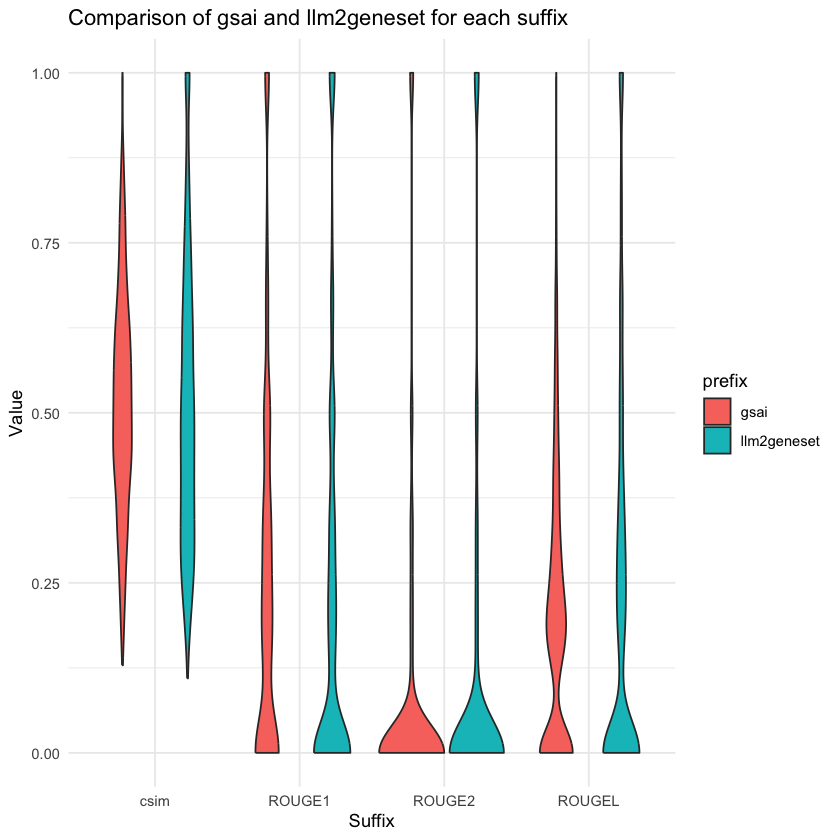

In [36]:
# Function to gather and create boxplots
create_boxplots <- function(data, prefix1, prefix2) {
   data <- data %>% 
    select(-model, -library, -gt_name, -gsai_name, -llm2geneset_name)
    print(head(data))

    # Gather data
  long_data <- data %>%
    gather(key = "variable", value = "value", everything()) %>%
    separate(variable, into = c("prefix", "suffix"), sep = "_", remove = FALSE)
  
  # Filter for the relevant prefixes
  filtered_data <- long_data %>%
    filter(prefix %in% c(prefix1, prefix2))
  
  # Create boxplot
  ggplot(filtered_data, aes(x = suffix, y = value, fill = prefix)) +
    geom_violin() +
    labs(title = paste("Comparison of", prefix1, "and", prefix2, "for each suffix"),
         x = "Suffix",
         y = "Value") +
    theme_minimal()
}

# Run the function with the example data
create_boxplots(res, "gsai", "llm2geneset")